<img src=images/Theatre1.png width="400" height="240">

banner-gcbea564f2_1920.jpg

# Recommendations for Microsoft's Brand New Movie Studio

**Authors:** Dietrich Nigh, Annie Zheng, Paul Schulken
***

<img src=images/banner-gcbea564f2_1920.jpg>

## Overview

With the return of theatrical movie releases, in addition to the increase in streaming video content, Microsoft has expressed interest in creating their own movie studio. To maximize their chances of success, they have requested an analysis of the best performing movies at the box office. The relationship between box office results and genre, awards votes, release seasonality and run times were analyzed to determine what combinations were most likely to produce popular and profitable movies.  This analysis explored those factors that tend to make a movie commercially and critically successful.

## Business Problem

Creating a movie studio is a big undertaking and therefore requires a good amount of forethought. Our statistical will assist Microsoft in determining the direction of their studio. Like any business, the studio must make money to remain operational so the box office results were focused on from the beginning. Profitability, genre, seasonality and run times were the main focuses of the analysis and were deemed to be vital to the success of a movie and the studio itself. What makes a high grossing movie? The team analyzed the gross profits compared to movie genres that most people took interest in as well as seasonality to determine the best release time. We also analyzed run times of movies to determine whether the length of a movie would affect a movie's likability. By determining the factors most correlated with box office success, Microsoft's new studio can use the results to produce movies with confidence that they'll be profitable and well received.

## Data Understanding

The data used in this analysis was taken from [IMDB](https://www.imdb.com/), [The Numbers](https://www.the-numbers.com/), and [The Movie DB](https://www.themoviedb.org/), websites that track multiple metrics related to movies and allow users to review and discuss these movies. The data files provided release dates, genre information, awards vote numbers, run time, production budgets as well as domestic and worldwide gross figures for thousands of movies. The target variables were the profits which laid a foundation for the rest of the analysis which dove deeper into their respective genres and release dates. The dataset primarily contains quantitative numerical data, with the instance of qualitative categorical data of genres. By representing profit, award vote counts, and release years and months as numbers, statistical analysis and conditional filtering could be performed.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

In [2]:
# Suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# Load data set 'tmdb.movies.csv.gz' with data obtained from TMDB
movies = pd.read_csv('zippedData//tmdb.movies.csv.gz')

# Load dataset 'tn.movie_budgets.csv.gz' with data obtained from The-Numbers
movie_budgets = pd.read_csv('zippedData//tn.movie_budgets.csv.gz')

# Connect and read in SQLite3 database
conn = sqlite3.connect('zippedData/im.db')

## Data Preparation

In order to perform our analysis, our team merged several tables together to obtain a full dataset. In doing so, we accumulated columns that contained duplicate or unnecessary data to our analysis and those columns were dropped. Data such as the numeric genre codes were changed to the respective genre titles that correlated to The Movie Database's database. Lastly, columns for Profit and Profit:Gross Ratio were calculated to be used in the visualizations.

The dataset includes movies released from 2009-2019 and was filtered for movies that had worldwide gross profit greater than the those within the 25th quartile. These changes were made to filter out the least popular movies in terms of critical reception and financial success. Identifying trends in the movies that remain in the data set allowed us to base our recommendations on the most well received movies.

In [4]:
# Merge the 'movie_basics' and 'movie_rating' tables together with a left join to create 'basics_and_ratings' 
# dataframe
basics_and_ratings = pd.read_sql("""
SELECT *
FROM movie_basics
LEFT JOIN movie_ratings
    ON movie_basics.movie_id = movie_ratings.movie_id
    """, conn )

The movie_basics and movie_ratings tables were selected as it contain most relevant product data for our analysis such as the run times of each movie and number of votes collected from movie watchers.

In [5]:
# Merge movie_budgets and movies with an inner join to create a 'masterdf' dataframe
masterdf = movie_budgets.merge(movies, how='inner', left_on='movie', right_on='title', \
                               suffixes=('_budgets', '_movies'))

In [6]:
# Merge the 'basics_and_ratings' and 'masterdf' dataframes with an inner join to create a 'new_masterdf' dataframe
new_masterdf = masterdf.merge(basics_and_ratings, how='inner', left_on='movie', right_on='primary_title', \
                              suffixes=('_master','_database')).drop_duplicates(subset='movie')

In [7]:
new_masterdf.head()

,id_budgets,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,Unnamed: 0,genre_ids,id_movies,original_language,...,vote_count,movie_id,primary_title,original_title_database,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",6,"[28, 12, 14, 878]",19995,en,...,18676,tt1775309,Avatar,Abatâ,2011,93.00000,Horror,tt1775309,6.10000,43.00000
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2470,"[12, 28, 14]",1865,en,...,8571,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00000,"Action,Adventure,Fantasy",tt1298650,6.60000,447624.00000
2,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",14169,"[28, 12, 878]",99861,en,...,13457,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.00000,"Action,Adventure,Sci-Fi",tt2395427,7.30000,665594.00000
3,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",23811,"[12, 28, 14]",299536,en,...,13948,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.00000,"Action,Adventure,Sci-Fi",tt4154756,8.50000,670926.00000
4,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",20623,"[28, 12, 14, 878]",141052,en,...,7510,tt0974015,Justice League,Justice League,2017,120.00000,"Action,Adventure,Fantasy",tt0974015,6.50000,329135.00000


In [8]:
# Drop columns with repeated information or information not relevant to analysis from the datasets
new_masterdf.drop(['id_movies', 'Unnamed: 0', 'original_title_database', 'movie_id', 'primary_title', 'title', \
                   'id_budgets', 'start_year', 'original_title_master', 'release_date_budgets', \
                   'vote_count', 'vote_average', 'popularity'], axis=1, inplace=True)

The following columns were dropped from the dataset for the following reasons:
* Columns 'id_movies', 'movie_id', and 'id_budgets' were the unique movie identification numbers from their respective datasets. These are no longer relevant identifers as each dataset has conflicting identification numbers and movies will be referenced by movie title rather than ID number. 
* Columns 'original_title_database', 'movie_id', 'primary_title', 'title', and 'original_title_master' contained repeated data of the movie title. 
* Column 'Unnamed: 0' was the index  from 'movies' dataset. 
* Columns 'start_year'and 'release_date_budgets' contained repeated information regarding release dates. 

In [9]:
# Define function to remove '$' and ',' from dataset
def remove_dollarsigncommas(data, column):
    data[column] = data[column].str.replace(',','')
    data[column] = data[column].str.replace('$','')
    return print('all done') ; print(data[column].head())

# Remove '$' and ',' from relevant columns
remove_dollarsigncommas(new_masterdf, 'production_budget')
remove_dollarsigncommas(new_masterdf, 'worldwide_gross')
remove_dollarsigncommas(new_masterdf, 'domestic_gross')

all done
all done
all done


/var/folders/v0/p588qkrd5kb8kdnf_3zrlbm80000gn/T/ipykernel_5959/3923268237.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace('$','')


In [10]:
# Cast the revelant columns as integers for data manipulation
new_masterdf[['production_budget', 'domestic_gross', 'worldwide_gross']] = new_masterdf \
[['production_budget', 'domestic_gross', 'worldwide_gross']].applymap(lambda x: int(x))

In [11]:
# Create 'release_month' column for data manipulation
new_masterdf['release_month'] = new_masterdf['release_date_movies'].map(lambda x: x[5:7])

# Create 'release_year' column for data manipulation
new_masterdf['release_year'] = new_masterdf['release_date_movies'].map(lambda x: int(x[:4]))

In [12]:
# Replace 'genre_ids' with respective TMDB genre names
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('28', 'Action')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('12', 'Adventure')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('16', 'Animation')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('35', 'Comedy')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('80', 'Crime')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('99', 'Documentary')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('18', 'Drama')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10751', 'Family')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('14', 'Fantasy')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('36', 'History')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('27', 'Horror')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10402', 'Music')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('9648', 'Mystery')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10749', 'Romance')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('878', 'Science Fiction')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10770', 'TV Movie')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('53', 'Thriller')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10752', 'War')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('37', 'Western')

The corresponding genre id numbers and names information was sourced from [TMDB Genre Assignment](https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee).

In [13]:
# Create new columns breaking down the genre types of each movie
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].map(lambda x: x.lstrip('[').rstrip(']').split(','))

In [14]:
# Reset the index
new_masterdf.reset_index(inplace=True)

In [15]:
# Merging the genre breakdown data with the master dataset with an left join to create 'final_df' dataframe
final_df = new_masterdf.join(pd.DataFrame(new_masterdf.genre_ids.values.tolist()).add_prefix('genre_'), how='left', \
                             lsuffix='_votes')

# Reset the column labeled index
final_df.drop('index', axis=1, inplace=True)

# Find the amount of missing data from each column
final_df.isna().sum()/len(final_df)

# Drop all 'genre_' breakdown columns where majority of data was missing
final_df.drop(['genre_6','genre_5','genre_4','genre_3', 'genre_2'], axis=1, inplace=True)

# Drop the 'genres' column 
final_df.drop('genres', axis=1, inplace=True)

In [16]:
# Find the counts of unique values of the original_language
final_df['original_language'].value_counts()

# Drop the original_language column as majority of movies are in English
final_df.drop('original_language', axis=1, inplace=True)

In [17]:
# Get the descriptive statistics of the 'worldwide_gross' column
final_df['worldwide_gross'].describe()

# Filter dataset based on worldwide gross profits
final_df = final_df[final_df['worldwide_gross'] > 3541565]

# Filter dataset based on movies released within last 10 years of dataset
final_df = final_df[final_df['release_year'] >= 2009]

# Additional column of the Net Profits
final_df['net_profits'] = final_df['worldwide_gross'] - final_df['production_budget']

# Additional column of the Profit to Budget Ratio
final_df['profit_to_budget_ratio'] = final_df['net_profits'] / final_df['production_budget']

# View the genre_0 makeup percentage
(final_df.groupby('genre_0').count()/len(final_df)).sort_values('movie', ascending=False)

# Drop the movies whose genre makes up less than 1% of the data 
final_df = final_df.loc[final_df['genre_0'] != 'TV Movie']
final_df = final_df.loc[final_df['genre_0'] != 'Western']
final_df = final_df.loc[final_df['genre_0'] != 'Music']
final_df = final_df.loc[final_df['genre_0'] != 'War']
final_df = final_df.loc[final_df['genre_0'] != 'History']
final_df = final_df.loc[final_df['genre_0'] != 'Mystery']

final_df

,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,release_date_movies,runtime_minutes,averagerating,numvotes,release_month,release_year,genre_0,genre_1,net_profits,profit_to_budget_ratio
0,Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",2009-12-18,93.00000,6.10000,43.00000,12,2009,Action,Adventure,2351345279,5.53258
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",2011-05-20,136.00000,6.60000,447624.00000,05,2011,Adventure,Action,635063875,1.54667
2,Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",2015-05-01,141.00000,7.30000,665594.00000,05,2015,Action,Adventure,1072413963,3.24384
3,Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",2018-04-27,149.00000,8.50000,670926.00000,04,2018,Adventure,Action,1748134200,5.82711
4,Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",2017-11-17,120.00000,6.50000,329135.00000,11,2017,Action,Adventure,355945209,1.18648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,Graduation Day,250000,23894000,23894000,[],2015-01-01,75.00000,5.00000,52.00000,01,2015,,None,23644000,94.57600
1723,Sleight,250000,3930990,3934450,"[Drama, Thriller, Action, Science Fiction]",2017-04-28,89.00000,5.90000,7074.00000,04,2017,Drama,Thriller,3684450,14.73780
1724,Like Crazy,250000,3395391,3728400,"[Drama, Romance]",2011-10-28,86.00000,6.70000,55841.00000,10,2011,Drama,Romance,3478400,13.91360
1725,Cube,250000,489220,8969065,[],2014-05-02,113.00000,NaN,NaN,05,2014,,None,8719065,34.87626


The dataset was filtered for movies that had worldwide gross profit greater than the those within the 25th quartile in order to analyze the movies that exceled and profited to a worldwide audience rather than domestically. Additionally, it was filtered to only the most recent decade of movies (2009-2019) in order to keep the analysis focused on current movie metrics.

## Diving into Analysis & Modeling

Charts were created to provide a visual reference for the master data set. Charting the highest grossing movies compared to their genre, release month or number of votes allows for quick identification of the most frequently occuring variables in successful movies. Statistical measures like the mean and bottom 25% quartile were applied to find average values across the dataset and remove the worst performing movies. We did not want the analyis to consider movies that performed poorly or were not representative of the data as a whole when making recommendations on how to produce profitable movies.

### Genre Analysis: The Battle of Genres

### Release Month Analysis: 

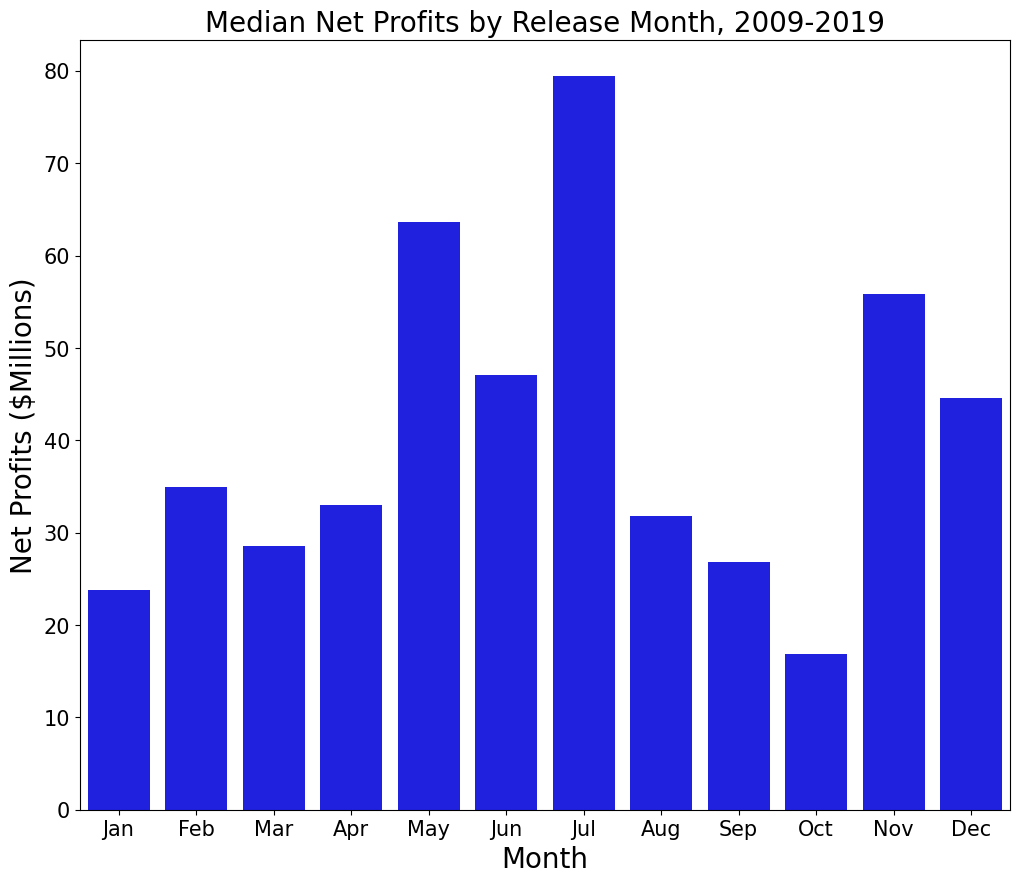

In [18]:
# View the median values of the dataset grouped by the release month
month_medians = final_df.groupby('release_month').median()

# Reset the index
month_medians.reset_index(drop=False, inplace=True)

# Plot the Median Net Profits by Release Month between 2009-2019
fig, ax = plt.subplots(figsize = (12 , 10))

y = month_medians['net_profits'] / 1000000
ticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = sns.barplot(data = month_medians,
                  x = 'release_month',
                  y = y,
                  color = 'blue',)

plt.xlabel('Month', size=20)
ax.set_xticklabels(ticklabels, size=15)
plt.ylabel('Net Profits ($Millions)', size=20)
plt.yticks(fontsize=15)
plt.title('Median Net Profits by Release Month, 2009-2019', size=20)
plt.show(fig);

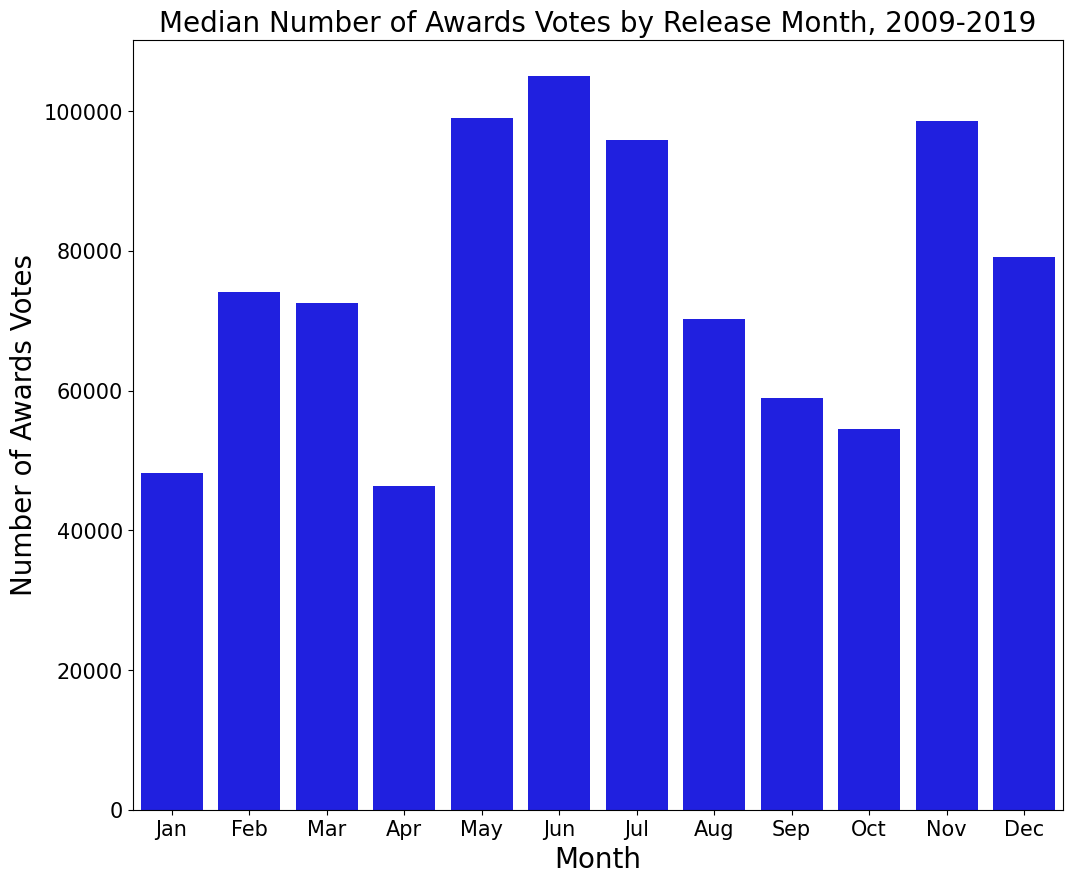

In [19]:
# Plot the Median Number of Awards Votes by Release Month between 2009-2019
fig, ax = plt.subplots(figsize = (12 , 10))

ticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = sns.barplot(data = month_medians,
                  x = 'release_month',
                  y = 'numvotes',
                  color = 'blue',)

plt.xlabel('Month', size=20)
ax.set_xticklabels(ticklabels, size=15)
plt.ylabel('Number of Awards Votes', size=20)
plt.yticks(fontsize=15)
plt.title('Median Number of Awards Votes by Release Month, 2009-2019', size=20)
plt.show(fig);

### Runtime Analysis: too short, too long, or just right? 

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

Many of the highest grossing movies are part of existing franchises or intellectual property. Audiences enjoy seeing movies based on stories and characters that they're already familiar with. The cost of acquiring pre-existing intellectual property was not factored in to this analysis.


## Conclusions

* Recommendation 1: Focus on an Animation Genre Movie
    * This genre of movie shows to have the highest profitability, including Worldwide gross, net profit, profit to production cost ratio. 
    * Based on audience votes, this genre is highly ranked.
    * The audience range for animated movies spans across the largest age range.
    
* Recommendation 2: Released the movie in the Summer or right before the Holidays in November
    * Movies released around these seasons profited the most. This can be attributed to the larger amount of freetime people have during these time periods.

* Recommendation 3: Do not be overly concerned with movie Run Time
    * There is no strong correlation with awards, profit, or ROI when comparing short vs. long run times.
  
  
Limitations:
* Missing data
* Dataset contains incorrect information, such as two movies having the same name. The release date would correlate with one movie, but the genre would correlate with the secondary movie.


Next Steps:
* Look into Streaming vs. Box office performance for genres
* Compare the data with historical data trends
